Training on cuda
[Epoch 1, Batch 100] Loss: 3.594 Accuracy: 5.95%
[Epoch 1, Batch 200] Loss: 2.550 Accuracy: 14.73%
[Epoch 1, Batch 300] Loss: 1.644 Accuracy: 26.57%
[Epoch 1, Batch 400] Loss: 1.067 Accuracy: 36.46%
[Epoch 1, Batch 500] Loss: 0.748 Accuracy: 44.57%
[Epoch 1, Batch 600] Loss: 0.539 Accuracy: 51.05%
[Epoch 1, Batch 700] Loss: 0.424 Accuracy: 56.27%
[Epoch 1, Batch 800] Loss: 0.336 Accuracy: 60.49%
[Epoch 1, Batch 900] Loss: 0.265 Accuracy: 63.99%
[Epoch 1, Batch 1000] Loss: 0.255 Accuracy: 66.82%
[Epoch 1, Batch 1100] Loss: 0.222 Accuracy: 69.25%
[Epoch 1, Batch 1200] Loss: 0.183 Accuracy: 71.35%
[Epoch 1, Batch 1300] Loss: 0.154 Accuracy: 73.20%
[Epoch 2, Batch 100] Loss: 0.109 Accuracy: 96.84%
[Epoch 2, Batch 200] Loss: 0.103 Accuracy: 96.93%
[Epoch 2, Batch 300] Loss: 0.102 Accuracy: 97.01%
[Epoch 2, Batch 400] Loss: 0.095 Accuracy: 97.05%
[Epoch 2, Batch 500] Loss: 0.101 Accuracy: 97.05%
[Epoch 2, Batch 600] Loss: 0.095 Accuracy: 97.08%
[Epoch 2, Batch 700] Loss: 0.0

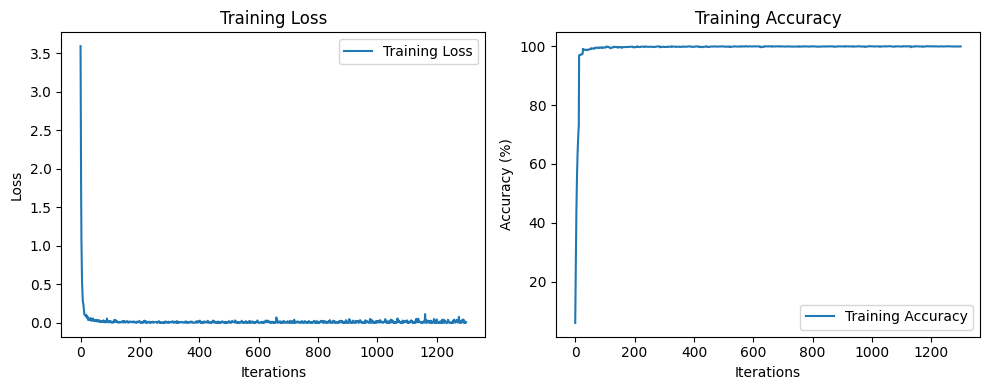

Accuracy on the test set: 94.96%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pickle

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on {device}")

# Load data from data0.pickle
google_drive_path = '/content/drive/MyDrive/Anul 3/pi/Proiect/'
with open(google_drive_path + 'data0.pickle', 'rb') as f:
    data0 = pickle.load(f, encoding='latin1')

X_train = data0['x_train']
y_train = data0['y_train']
X_test = data0['x_test']
y_test = data0['y_test']

X_train = torch.tensor(X_train, dtype=torch.float32) / 255.0
X_test = torch.tensor(X_test, dtype=torch.float32) / 255.0
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Move data to the GPU if available
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 43)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model, move it to the GPU if available
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the model
epochs = 100
train_loss_history = []
train_acc_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader, 0):
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if i % 100 == 99:
            print(f"[Epoch {epoch + 1}, Batch {i + 1}] Loss: {running_loss / 100:.3f} Accuracy: {correct / total * 100:.2f}%")
            train_loss_history.append(running_loss / 100)
            train_acc_history.append(correct / total * 100)
            running_loss = 0.0

# Plot training loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy on the test set: {accuracy * 100:.2f}%")

# Save the model
torch.save(model, google_drive_path + 'model.pt')


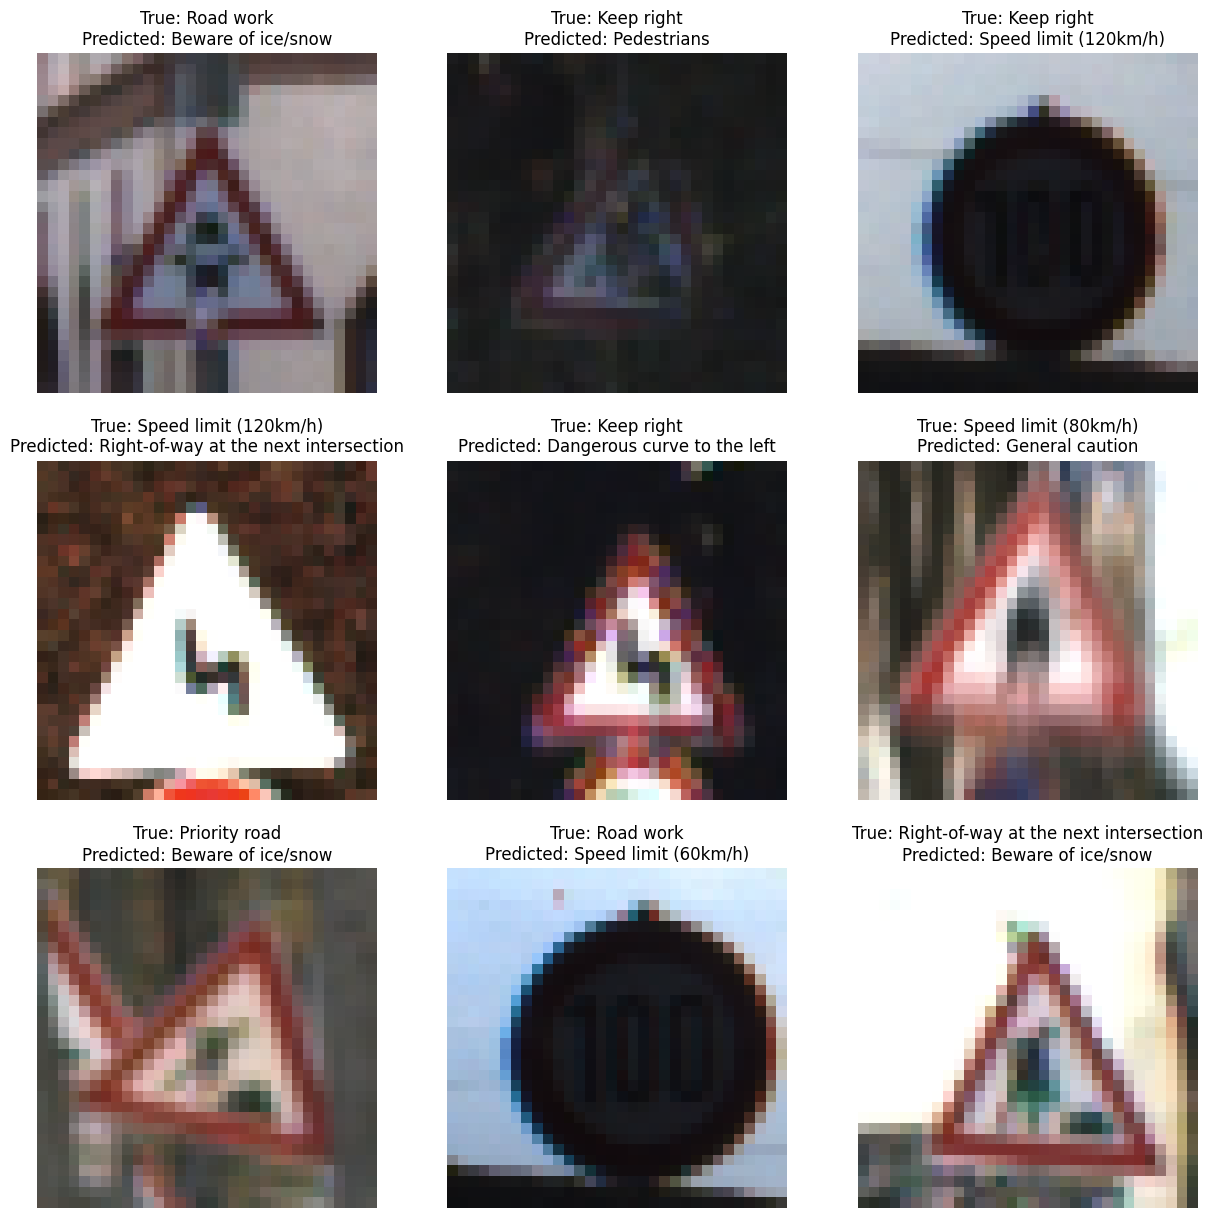

In [25]:
import pandas as pd

# Load label names
label_names_df = pd.read_csv(google_drive_path + 'label_names.csv')

# Function to get class name from class index
def get_class_name(class_index):
    return label_names_df[label_names_df['id'] == class_index]['name'].values[0]

# Evaluation
model.eval()
incorrect_indices = []
correct_labels = []
incorrect_labels = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        incorrect_mask = predicted != labels
        incorrect_indices.extend((i * 64) + j for j, value in enumerate(incorrect_mask) if value)
        correct_labels.extend(labels[~incorrect_mask].cpu().numpy())
        incorrect_labels.extend(predicted[incorrect_mask].cpu().numpy())

        if len(incorrect_indices) >= 9:
            break

# Plot 9 incorrect predictions
plt.figure(figsize=(15, 15))
for i, idx in enumerate(incorrect_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx].cpu().numpy().transpose((1, 2, 0)))  # Assuming X_test is in CHW format
    plt.title(f"True: {get_class_name(correct_labels[i])}\nPredicted: {get_class_name(incorrect_labels[i])}")
    plt.axis('off')

plt.show()


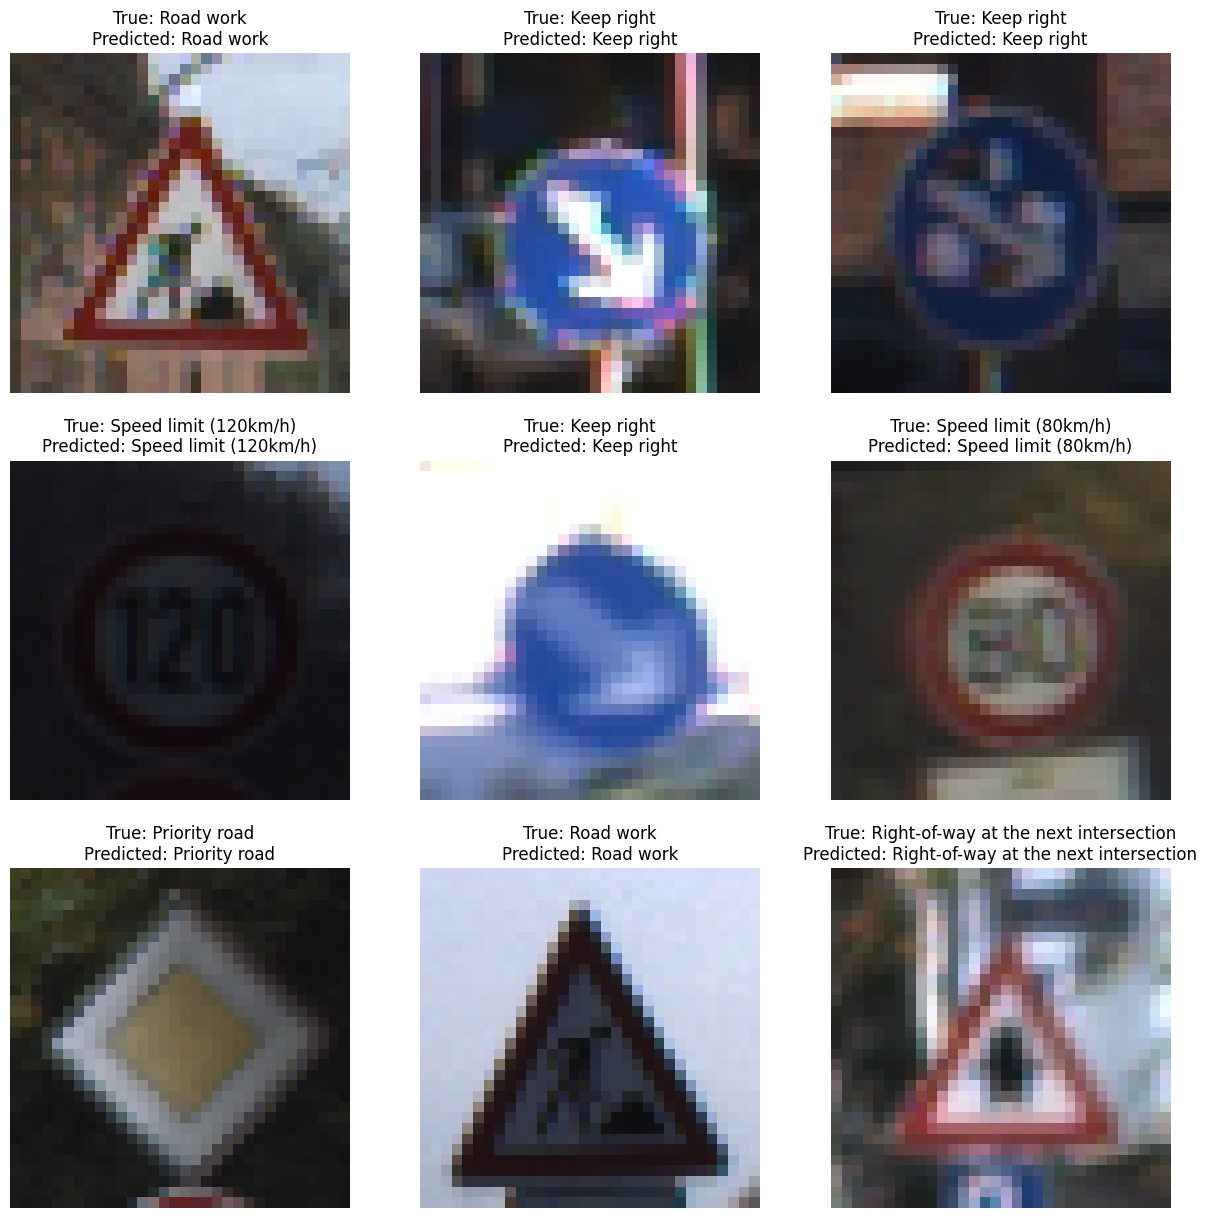

In [27]:
import pandas as pd

# Load label names
label_names_df = pd.read_csv(google_drive_path + 'label_names.csv')

# Function to get class name from class index
def get_class_name(class_index):
    return label_names_df[label_names_df['id'] == class_index]['name'].values[0]
# Evaluation
model.eval()
correct_indices = []
correct_labels = []
predicted_labels = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(test_loader):
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_mask = predicted == labels
        correct_indices.extend((i * 64) + j for j, value in enumerate(correct_mask) if value)
        correct_labels.extend(labels[correct_mask].cpu().numpy())
        predicted_labels.extend(predicted[correct_mask].cpu().numpy())

        if len(correct_indices) >= 9:
            break

# Plot 9 correct predictions
plt.figure(figsize=(15, 15))
for i, idx in enumerate(correct_indices[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx].cpu().numpy().transpose((1, 2, 0)))  # Assuming X_test is in CHW format
    plt.title(f"True: {get_class_name(correct_labels[i])}\nPredicted: {get_class_name(predicted_labels[i])}")
    plt.axis('off')

plt.show()
